In [5]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [6]:
import keras as keras
tf.__version__

'2.9.2'

In [11]:
!tf_upgrade_v2 -h

usage: tf_upgrade_v2 [-h] [--infile INPUT_FILE] [--outfile OUTPUT_FILE]
                     [--intree INPUT_TREE] [--outtree OUTPUT_TREE]
                     [--copyotherfiles COPY_OTHER_FILES] [--inplace]
                     [--no_import_rename] [--no_upgrade_compat_v1_import]
                     [--reportfile REPORT_FILENAME] [--mode {DEFAULT,SAFETY}]
                     [--print_all]

Convert a TensorFlow Python file from 1.x to 2.0

Simple usage:
  tf_upgrade_v2.py --infile foo.py --outfile bar.py
  tf_upgrade_v2.py --infile foo.ipynb --outfile bar.ipynb
  tf_upgrade_v2.py --intree ~/code/old --outtree ~/code/new

optional arguments:
  -h, --help            show this help message and exit
  --infile INPUT_FILE   If converting a single file, the name of the file to
                        convert
  --outfile OUTPUT_FILE
                        If converting a single file, the output filename.
  --intree INPUT_TREE   If converting a whole tree of files, the directory to
        

In [16]:
!tf_upgrade_v2 \
  --infile /content/multiLSTM.py \
  --outfile /content/multiLSTM_tf_v2.py

TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 1 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



 Training LSTM 1 ...
Epoch 1/15
16/16 [==============================] - 2s 29ms/step - loss: 0.1971 - val_loss: 0.1253
Epoch 2/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1609 - val_loss: 0.1392
Epoch 3/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1539 - val_loss: 0.1407
Epoch 4/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1486 - val_loss: 0.1305
Epoch 5/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1452 - val_loss: 0.1343
Epoch 6/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1399 - val_loss: 0.1186
Epoch 7/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1344 - val_loss: 0.1378
Epoch 8/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1309 - val_loss: 0.1158
Epoch 9/15
16/16 [==============================] - 0s 6ms/step - loss: 0.1290 - val_loss: 0.1161
Epoch 10/15
16/16 [==============================] - 0s 5ms/step - loss: 0.1265 - val_loss: 0.11

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

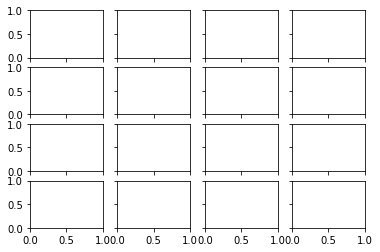

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D
from keras.layers import LSTM, SimpleRNN, GRU
import keras as keras
np.random.seed(1234)
from keras import backend as K

class multiLSTM:
    def __init__(self):
        self.inputHorizon = 12 # number of time steps as input
        self.inOutVecDim = 57  # number of stations
        self.lstmModels = [ None for _ in range(6)]
        self.xTest, self.yTest = None, None
        file_dataset = '/content/MS_winds_dummy.dat'
        with open(file_dataset) as f:
            data = csv.reader(f, delimiter=",")
            winds = []
            for line in data:
                winds.append((line))
        self.winds = (np.array(winds)).astype(float) # all data
        self.winds = self.winds[:,:self.inOutVecDim]
        self.means_stds = [0,0]
        self.winds, self.means_stds = self.normalize_winds_0_1(self.winds)
        self.validation_split = 0.05
        self.batchSize = 3
        activation = ['sigmoid',   "tanh",   "relu", 'linear']
        self.activation = activation[2]
        realRun = 1
        #          model number :           1   2   3   4   5   6
        self.epochs, self.trainDataRate = [[15, 17, 15, 17, 15, 15], 1] if realRun else [[ 1, 1, 1, 1, 1, 1] , 0.005]# percentage of data used for training(saving time for debuging)

    def normalize_winds_0_1(self, winds):
        '''normalize based on each station data'''
        stations = winds.shape[1]
        normal_winds = []
        mins_maxs = []
        windMax = winds.max()
        windMin = winds.min()
        normal_winds = (winds - windMin) / windMax
        mins_maxs = [windMin, windMax]
        return np.array(normal_winds), mins_maxs

    def denormalize(self, vec):
        res = vec * self.means_stds[1] + self.means_stds[0]        #  fro 0 to 1
        return res

    def loadData_1(self):
        # for lstm1 output xtrain ytrain
        result = []
        for index in range(len(self.winds) - self.inputHorizon):
            result.append(self.winds[index:index + self.inputHorizon])
        result = np.array(result)  

        trainRow = int(6000 * self.trainDataRate)
        X_train = result[:trainRow, :]
        y_train = self.winds[self.inputHorizon:trainRow + self.inputHorizon]
        self.xTest = result[6000:6361, :]
        self.yTest = self.winds[6000 + self.inputHorizon:6361 + self.inputHorizon]
        self.predicted = np.zeros_like(self.yTest)
        return [X_train, y_train]

    def loadData(self, preXTrain, preYTrain, model): # xtrain and ytrain from loadData_1
        # for lstm2 output: xtrain ytrain
        xTrain, yTrain = np.ones_like(preXTrain), np.zeros_like(preYTrain)
  
        for ind in range(len(preXTrain) - self.inputHorizon -1):
            tempInput = preXTrain[ind]
            temp_shape = tempInput.shape
            tempInput = np.reshape(tempInput, (1,temp_shape[0],temp_shape[1]))
            output = model.predict(tempInput)
            tInput = np.reshape(tempInput,temp_shape)
            tempInput = np.vstack((tInput, output))
            tempInput = np.delete(tempInput, 0, axis=0)
            xTrain[ind] = tempInput
            yTrain[ind] = preYTrain[ind+1]
        return [xTrain, yTrain]

  
    def buildModelLSTM_1(self):
        model = Sequential()
        in_nodes = out_nodes = self.inOutVecDim
        layers = [in_nodes, 57*2, 57, 32, out_nodes]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))
    
        model.add(Dense(
            units=layers[4]))
        model.add(Activation(self.activation))
    
        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_2(self):
        model = Sequential()
        layers = [self.inOutVecDim, 10 , 57 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_3(self):
        model = Sequential()

        layers = [self.inOutVecDim, 57, 57 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_4(self):
        model = Sequential()

        layers = [self.inOutVecDim, 57, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=True))

        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_5(self):
        model = Sequential()

        layers = [self.inOutVecDim, 30, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_6(self):
        model = Sequential()
        layers = [self.inOutVecDim, 57*2, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
        return_sequences=True))


        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM(self, lstmModelNum):
        if   lstmModelNum == 1:
            return self.buildModelLSTM_1()
        elif lstmModelNum == 2:
            return self.buildModelLSTM_2()
        elif lstmModelNum == 3:
            return self.buildModelLSTM_3()
        elif lstmModelNum == 4:
            return self.buildModelLSTM_4()
        elif lstmModelNum == 5:
            return self.buildModelLSTM_5()
        elif lstmModelNum == 6:
            return self.buildModelLSTM_6()

    def trainLSTM(self, xTrain, yTrain, lstmModelNum):
        # train first LSTM with inputHorizon number of real input values

        lstmModel = self.buildModelLSTM(lstmModelNum)
        lstmModel.fit(xTrain, yTrain, batch_size=self.batchSize, epochs=self.epochs[lstmModelNum-1], validation_split=self.validation_split)
        return lstmModel

    def test(self):
        ''' calculate the predicted values(self.predicted) '''
        for ind in range(len(self.xTest)):
            modelInd = ind % 6
            if modelInd == 0:
                testInputRaw = self.xTest[ind]
                testInputShape = testInputRaw.shape
                testInput = np.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
            else :
                testInputRaw = np.vstack((testInputRaw, self.predicted[ind-1]))
                testInput = np.delete(testInputRaw, 0, axis=0)
                testInputShape = testInput.shape
                testInput = np.reshape(testInput, [1, testInputShape[0], testInputShape[1]])

            self.predicted[ind] = self.lstmModels[modelInd].predict(testInput)

        return

    def errorMeasures(self, denormalYTest, denormalYPredicted):

        mae = np.mean(np.absolute(denormalYTest - denormalYPredicted))
        rmse = np.sqrt((np.mean((np.absolute(denormalYTest - denormalYPredicted)) ** 2)))
        nrsme_maxMin = 100*rmse / (denormalYTest.max() - denormalYTest.min())
        nrsme_mean = 100 * rmse / (denormalYTest.mean())

        return mae, rmse, nrsme_maxMin, nrsme_mean

    def drawGraphStation(self, station, visualise = 1, ax = None ):
        '''draw graph of predicted vs real values'''

        yTest = self.yTest[:, station]
        denormalYTest = self.denormalize(yTest)

        denormalPredicted = self.denormalize(self.predicted[:, station])

        mae, rmse, nrmse_maxMin, nrmse_mean  = self.errorMeasures(denormalYTest, denormalPredicted)
        print( ('station %s : MAE = %7.7s   RMSE = %7.7s    nrmse_maxMin = %7.7s   nrmse_mean = %7.7s'%(station+1, mae, rmse, nrmse_maxMin, nrmse_mean )))

        if visualise:
            if ax is None :
                fig = plt.figure()
                ax = fig.add_subplot(111)

            ax.plot(denormalYTest, label='Real')
            ax.plot(denormalPredicted, label='Predicted', color='red')
            ax.set_xticklabels([0, 100, 200, 300], rotation=40)

        return mae, rmse, nrmse_maxMin, nrmse_mean

    def drawGraphAllStations(self):
        rows, cols = 4, 4
        maeRmse = np.zeros((rows*cols,4))

        fig, ax_array = plt.subplots(rows, cols, sharex=True, sharey=True )
        staInd = 0
        for ax in np.ravel(ax_array):
            maeRmse[staInd] = self.drawGraphStation(staInd, visualise=1, ax=ax)
            staInd += 1
        plt.xticks([0, 100, 200, 300])#, rotation=45)
        errMean = maeRmse.mean(axis=0)
        print( maeRmse.mean(axis=0))

        filename = 'pgf/finalEpoch'
        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.show()

        return

    def run(self):
        #  training
        xTrain, yTrain = self.loadData_1()
        print (' Training LSTM 1 ...')
        self.lstmModels[0] = self.trainLSTM(xTrain, yTrain, 1)

        for modelInd in range(1,6):
            xTrain, yTrain = self.loadData(xTrain, yTrain, self.lstmModels[modelInd-1])
            print (' Training LSTM %s ...' % (modelInd+1))
            self.lstmModels[modelInd] = self.trainLSTM(xTrain, yTrain, modelInd+1)

        # testing
        print ('...... TESTING  ...')
        self.test()

        self.drawGraphAllStations()

DeepForecaste = multiLSTM()
DeepForecaste.run()
